# Installation

In [1]:
# pip install gensim requests rouge bert_score openpyxl prettytable nltk gdown

In [2]:
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('punkt_tab')

In [3]:
# import gdown
# import gzip
# import shutil
# import os

# compressed_path = "./GoogleNews-vectors-negative300.bin.gz"
# decompressed_path = "./GoogleNews-vectors-negative300.bin"


# # Google Drive file ID extracted from the link
# file_id = "0B7XkCwpI5KDYNlNUTTlSS21pQmM"

# # Download the file
# gdown.download(f"https://drive.google.com/uc?id={file_id}&export=download", compressed_path, quiet=False)

# print("Download completed.")


# # Extract the .bin file from .gz
# with gzip.open(compressed_path, "rb") as f_in:
#     with open(decompressed_path, "wb") as f_out:
#         shutil.copyfileobj(f_in, f_out)

# print("Extraction completed.")

# # (Optional) Delete the .gz file after extraction
# os.remove(compressed_path)
# print("Deleted the compressed file.")

# Performance Evaluation

In [1]:
import pandas as pd
import warnings
import logging

warnings.filterwarnings("ignore")
logging.getLogger('transformers').setLevel(logging.ERROR)

# Set the logging level to ERROR to ignore warnings
logging.getLogger("transformers").setLevel(logging.ERROR)


In [2]:
DATASET = "FoCus"                      

COT_ = ""                                               # "",  "-COT"

SCORING_METHOD = "length_prior"                                   # "avg",  "length_prior", "benchmark", "train"
LLM = f"Qwen2-5B-Instruct-{SCORING_METHOD}"             # Mistral-7B-Instruct, Llama3-1-8B-Instruct, Qwen2-7B-Instruct, Qwen2-5B-Instruct, gpt-3.5-turbo, gpt-4o-mini, gpt-4-turbo
SET = "valid"

COT_SETUP = True if COT_ == "-COT" else False

In [3]:
df = pd.read_csv(f'./Prompts/{DATASET}-{SET}.csv')            #Only for train set

print("Shape:", df.shape)

df.head(2)

Shape: (1000, 3)


,personas,context,act_response
0,I would like to visit the Nazareth House again...,User1: I think Ive been there before but I don...,User2: The history of the house you are intere...
1,I have been to Vermont a few times to go skiin...,"User1: Wow, this is amazing! What is this?\nUs...",User2: This house was use as a stop for slaves...


In [4]:
### Only For: FoCus, IT-ConvAI2

df['act_response'] = df['act_response'].apply(lambda x: x.split(':', 1)[1].strip() if ':' in x else x.strip())

print(df.isnull().sum())
df.head(2)

personas        0
context         0
act_response    0
dtype: int64


,personas,context,act_response
0,I would like to visit the Nazareth House again...,User1: I think Ive been there before but I don...,The history of the house you are interested in...
1,I have been to Vermont a few times to go skiin...,"User1: Wow, this is amazing! What is this?\nUs...",This house was use as a stop for slaves trying...


In [5]:
response = pd.read_csv(f'Responses/{DATASET}/{LLM}{COT_}.csv')
print("Shape:", response.shape)

print("\nMissing Values:")
print(response.isnull().sum())

response

Shape: (1000, 2)

Missing Values:
gen_response     148
response_time      0
dtype: int64


,gen_response,response_time
0,NaN,0.226154
1,That's fascinating! It's possible to learn abo...,0.226543
2,That's fascinating! That's a unique architectu...,0.891380
3,NaN,0.739077
4,"To'sailors', see the impressive Harrison & Har...",0.743324
...,...,...
995,That's great to hear! Enjoy your visit to Quee...,0.232064
996,"Ah, that's fascinating! Visiting ancient forts...",0.466092
997,That's interesting! Visiting Armagh County Mus...,0.736617
998,Hiking through the rainforest at Nyanga Nation...,0.638661


In [6]:
# Calculate maximum number of words in each column
max_response_length = response['gen_response'].dropna().apply(lambda x: len(x.split())).max()

print(f"Maximum Response Length (in words): {max_response_length}")

Maximum Response Length (in words): 31


In [7]:
import pandas as pd
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Initialize stop words
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text, remove_stop_words=True):
    if pd.isnull(text):
        return None
    text = text.lower()  # Lowercasing
    text = text.translate(str.maketrans('', '', string.punctuation))  # Removing punctuation
    tokens = word_tokenize(text)  # Tokenization
    if remove_stop_words:
        tokens = [word for word in tokens if word not in stop_words]  # Removing stop words
    return ' '.join(tokens)  # Join tokens back into a single string


# Create eval_df
eval_df = pd.DataFrame({
    'personas': df['personas'],
    'context': df['context'],
    'act_response': df['act_response'],
    'gen_response': response['gen_response'],
    'response_time': response['response_time']
})

print(eval_df.isnull().sum())
eval_df.head()

personas           0
context            0
act_response       0
gen_response     148
response_time      0
dtype: int64


,personas,context,act_response,gen_response,response_time
0,I would like to visit the Nazareth House again...,User1: I think Ive been there before but I don...,The history of the house you are interested in...,NaN,0.226154
1,I have been to Vermont a few times to go skiin...,"User1: Wow, this is amazing! What is this?\nUs...",This house was use as a stop for slaves trying...,That's fascinating! It's possible to learn abo...,0.226543
2,I am fascinated by the Spanish Colonial Reviva...,"User1: Wow, this is amazing! What is this?\nUs...","Sure, you will like to know that this place wa...",That's fascinating! That's a unique architectu...,0.891380
3,I want to become a college student.I want to s...,User1: Where is this place?\nUser2: Hello! Wel...,Technische Universität Darmstadt in the top 25...,NaN,0.739077
4,I like to visit england.I love church.I would ...,User1: Where is this place?\nUser2: This place...,"I suggest a place, for your wish of see librar...","To'sailors', see the impressive Harrison & Har...",0.743324


In [8]:
print(eval_df.isnull().sum())

personas           0
context            0
act_response       0
gen_response     148
response_time      0
dtype: int64


In [9]:
import torch
device = 0 if torch.cuda.is_available() else -1  # device set to 0 for GPU, -1 for CPU

In [10]:
from transformers import pipeline, BertForSequenceClassification, BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from transformers import pipeline
from tqdm import tqdm
import pandas as pd
import numpy as np
import gensim
import sys
import os


# Add UniEval to PYTHONPATH
sys.path.append(os.path.abspath("UniEval"))  # Update with your actual path

from UniEval.utils import convert_to_json
from UniEval.metric.evaluator import get_evaluator


# Lists to store the metrics
ue_scores = []
c_scores = []
persona_distance_scores = []
coh_unieval_scores = []


bert_snli_dir = "Fine-tuning/output/bert_snli"
bert_snli_model = BertForSequenceClassification.from_pretrained(bert_snli_dir)
bert_snli_tokenizer = BertTokenizer.from_pretrained(bert_snli_dir)

# Initialize the NLI pipeline for UE Score
bert_on_snli = pipeline('text-classification', model = bert_snli_model, tokenizer = bert_snli_tokenizer, device=0)

bert_dnli_dir = "Fine-tuning/output/bert_dnli"
bert_dnli_model = BertForSequenceClassification.from_pretrained(bert_dnli_dir)
bert_dnli_tokenizer = BertTokenizer.from_pretrained(bert_dnli_dir)

# Initialize the NLI pipeline
bert_on_dnli = pipeline('text-classification', model = bert_dnli_model, tokenizer = bert_dnli_tokenizer, device=0)


# Initialize the Word2Vec Model
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format("./GoogleNews-vectors-negative300.bin", binary=True)
stop_words = set(stopwords.words('english'))



def batch_calculate_c_scores(gen_responses, personas):
    """
    Batched version of calculate_c_score using DNLI model.
    """
    assert len(gen_responses) == len(personas), "Mismatched input lengths"

    inputs = [f"{p} {r}" for p, r in zip(personas, gen_responses)]
    results = bert_on_dnli(inputs)

    label_mapping = {
        'LABEL_0': 'negative',
        'LABEL_1': 'neutral',
        'LABEL_2': 'positive'
    }

    scores = []
    for result in results:
        label = label_mapping.get(result['label'], 'unknown')
        if label == 'positive':
            scores.append(1)
        elif label == 'neutral':
            scores.append(0)
        elif label == 'negative':
            scores.append(-1)
        else:
            scores.append(None)
    return scores


def batch_calculate_ue_scores(act_responses, gen_responses, personas):
    """
    Batched version of calculate_ue_score using SNLI model.
    Returns a list of UE scores (0, 1, or 2).
    """
    assert len(act_responses) == len(gen_responses) == len(personas), "Mismatched lengths."

    # Prepare NLI inputs
    inputs_pr = [f"{p} [SEP] {r}" for p, r in zip(personas, gen_responses)]
    inputs_qr = [f"{q} [SEP] {r}" for q, r in zip(act_responses, gen_responses)]

    # Run both batches
    results_pr = bert_on_snli(inputs_pr)
    results_qr = bert_on_snli(inputs_qr)

    label_mapping = {
        'LABEL_0': 'entailment',
        'LABEL_1': 'neutral',
        'LABEL_2': 'contradiction'
    }

    scores = []
    for res_pr, res_qr in zip(results_pr, results_qr):
        label_pr = label_mapping.get(res_pr['label'], 'unknown')
        label_qr = label_mapping.get(res_qr['label'], 'unknown')

        if label_pr == 'entailment' and label_qr == 'entailment':
            scores.append(2)
        elif label_pr == 'entailment':
            scores.append(1)
        else:
            scores.append(0)
    return scores



def batch_calculate_coh_unieval_scores(personas_list, contexts_list, gen_responses_list):
    """
    Batched coherence scoring using UniEval evaluator.
    """
    # Ensure personas are joined as single strings
    personas_list = [' '.join(p) if isinstance(p, list) else p for p in personas_list]
    
    # Convert to UniEval input format
    data = convert_to_json(
        output_list=gen_responses_list,
        src_list=contexts_list,
        context_list=personas_list
    )
    
    # Load UniEval dialogue evaluator only once
    evaluator = get_evaluator('dialogue')
    eval_scores = evaluator.evaluate(data, print_result=False)

    # Extract coherence scores
    return [s.get("coherence", None) for s in eval_scores]




def compute_persona_distance(persona, response, model, stop_words):
    # Tokenize and filter stopwords
    persona_tokens = [word for word in persona.lower().split() if word not in stop_words]
    response_tokens = [word for word in response.lower().split() if word not in stop_words]
    
    # Get word vectors
    persona_vecs = [model[word] for word in persona_tokens if word in model]
    response_vecs = [model[word] for word in response_tokens if word in model]
    
    # If no vectors found, return zero similarity
    if not persona_vecs or not response_vecs:
        return 0.0
    
    # Compute average vectors
    persona_avg_vec = np.mean(persona_vecs, axis=0)
    response_avg_vec = np.mean(response_vecs, axis=0)
    
    # Compute cosine similarity
    return cosine_similarity([persona_avg_vec], [response_avg_vec])[0][0]



Device set to use cuda:0
Device set to use cuda:0


In [11]:
import logging

# Set the logging level to ERROR to suppress warnings about training
logging.getLogger("transformers").setLevel(logging.ERROR)

# Default worst-case values
worst_c_score = -1.0
worst_ue_score = 0.0
worst_persona_distance_score = 0.0
worst_coh_unieval_score = 0.0

In [12]:
from tqdm import tqdm

# Identify valid rows (non-null gen_response)
valid_mask = eval_df['gen_response'].notna()
valid_indices = eval_df[valid_mask].index.tolist()

# Extract valid inputs
valid_personas = eval_df.loc[valid_indices, 'personas'].tolist()
valid_act_responses = eval_df.loc[valid_indices, 'act_response'].tolist()
valid_contexts = eval_df.loc[valid_indices, 'context'].tolist()
valid_gen_responses = eval_df.loc[valid_indices, 'gen_response'].tolist()

# === Compute batch metrics with tqdm logging ===
print("Calculating C Scores...")
c_scores_batch = batch_calculate_c_scores(valid_gen_responses, valid_personas)

print("Calculating UE Scores...")
ue_scores_batch = batch_calculate_ue_scores(valid_act_responses, valid_gen_responses, valid_personas)

print("Calculating UniEval Coherence Scores...")
coh_unieval_batch_scores = batch_calculate_coh_unieval_scores(valid_personas, valid_contexts, valid_gen_responses)

# Initialize all score lists with worst-case values
c_scores = [worst_c_score] * len(eval_df)
ue_scores = [worst_ue_score] * len(eval_df)
coh_unieval_scores = [worst_coh_unieval_score] * len(eval_df)

# Fill valid indices with batch results using progress bar
print("Filling final metric arrays...")
for i, c, ue, coh in tqdm(zip(valid_indices, c_scores_batch, ue_scores_batch, coh_unieval_batch_scores),
                          total=len(valid_indices), desc="Populating Scores"):
    c_scores[i] = c
    ue_scores[i] = ue
    coh_unieval_scores[i] = coh

Calculating C Scores...
Calculating UE Scores...
Calculating UniEval Coherence Scores...
Filling final metric arrays...


Populating Scores: 100%|██████████| 852/852 [00:00<00:00, 3503477.46it/s]


In [13]:
# Iterate over each row
for index, row in tqdm(eval_df.iterrows(), total=len(eval_df)):
    personas = row['personas']
    contexts = row['context']
    act_response = row['act_response']
    gen_response = row['gen_response']
    
    # Check for NaN or None in gen_response
    if pd.isna(gen_response):
    
        persona_distance_scores.append(worst_persona_distance_score)
        
        continue

    persona_distance_scores.append(compute_persona_distance(personas, gen_response, word2vec_model,stop_words))

# Compile metrics into DataFrame
metrics_df = pd.DataFrame({
    'Coh-UniEval': coh_unieval_scores,
    'C Score': c_scores,
    'UE Score': ue_scores,
    'Persona Distance': persona_distance_scores
})

metrics_df

100%|██████████| 1000/1000 [00:00<00:00, 4037.95it/s]


,Coh-UniEval,C Score,UE Score,Persona Distance
0,0.000000,-1.0,0.0,0.000000
1,0.406118,0.0,0.0,0.643948
2,0.901196,0.0,0.0,0.545706
3,0.000000,-1.0,0.0,0.000000
4,0.990323,0.0,0.0,0.492057
...,...,...,...,...
995,0.983899,1.0,0.0,0.525340
996,0.957028,1.0,0.0,0.659428
997,0.891279,1.0,1.0,0.531612
998,0.473538,0.0,0.0,0.512900


In [14]:
## Storing the full results
output_path = f'./Metrics Results/{DATASET}/{LLM}{COT_}-results.xlsx'

df_concat = pd.concat([eval_df, metrics_df], axis=1)

df_concat.to_excel(output_path, index=False)

# Load and Aggregate Results

In [15]:
import pandas as pd

df = pd.read_excel(f"Metrics Results/{DATASET}/{LLM}-results.xlsx")
metrics_df = df.drop(columns=["personas", "context", "act_response","gen_response"])
metrics_df

,response_time,Coh-UniEval,C Score,UE Score,Persona Distance
0,0.226154,0.000000,-1,0,0.000000
1,0.226543,0.406118,0,0,0.643948
2,0.891380,0.901196,0,0,0.545706
3,0.739077,0.000000,-1,0,0.000000
4,0.743324,0.990323,0,0,0.492057
...,...,...,...,...,...
995,0.232064,0.983899,1,0,0.525340
996,0.466092,0.957028,1,0,0.659428
997,0.736617,0.891279,1,1,0.531612
998,0.638661,0.473538,0,0,0.512900


In [16]:
# Calculate the mean (average) and standard deviation, rounded to 2 decimal places
avg_values = metrics_df.mean().round(2)
std_values = metrics_df.std(ddof=0).round(2)  # Use ddof=0 for population standard deviation

# Combine the average and standard deviation into the format "avg ± std"
combined_values = avg_values.astype(str) + " ± " + std_values.astype(str)

# Insert the LLM name at the beginning of the combined values
combined_values = combined_values.tolist()
combined_values.insert(0, LLM)

# Create a DataFrame for the combined average ± std row
result_df = pd.DataFrame([combined_values], columns=['Model'] + metrics_df.columns.tolist())

# Add the ratio of invalid gen_response
invalid_gen_res_ratio = df['gen_response'].isna().sum() /len(df) 

result_df['Failure Ratio'] = f"{round(invalid_gen_res_ratio, 3)} ± 0.00"  # No std for Failure Ratio

result_df

,Model,response_time,Coh-UniEval,C Score,UE Score,Persona Distance,Failure Ratio
0,Qwen2-5B-Instruct-length_prior,0.49 ± 0.26,0.66 ± 0.36,0.18 ± 0.71,0.31 ± 0.64,0.47 ± 0.23,0.148 ± 0.00


In [17]:
# Load the existing Excel file and update or append the average row
output_path = f'./Evaluations/{DATASET}{COT_}-results.xlsx'

try:
    # Load existing data
    existing_df = pd.read_excel(output_path)
    # Check if the model name already exists
    if LLM in existing_df['Model'].values:
        # Update the row with the same model name
        existing_df.loc[existing_df['Model'] == LLM, :] = result_df.values
    else:
        # Append the new data
        existing_df = pd.concat([existing_df, result_df], ignore_index=True)
except FileNotFoundError:
    # If the file does not exist, create a new DataFrame
    existing_df = result_df

# Save the updated DataFrame to an Excel file
existing_df.to_excel(output_path, index=False)

existing_df

,Model,response_time,Coh-UniEval,C Score,UE Score,Persona Distance,Failure Ratio
0,Qwen2-7B-benchmark,4.02 ± 0.48,0.37 ± 0.48,-0.37 ± 0.87,0.16 ± 0.48,0.22 ± 0.29,0.627 ± 0.00
1,Qwen2-5B-avg-1855-complete,0.63 ± 0.25,0.24 ± 0.42,-0.61 ± 0.67,0.08 ± 0.35,0.16 ± 0.26,0.712 ± 0.00
2,Qwen2-5B-length_prior-1855-complete,0.45 ± 0.23,0.38 ± 0.48,-0.53 ± 0.67,0.09 ± 0.36,0.21 ± 0.27,0.608 ± 0.00
3,Qwen2-5B-Instruct-train,0.78 ± 0.15,0.6 ± 0.49,-0.14 ± 0.83,0.12 ± 0.44,0.29 ± 0.26,0.395 ± 0.00
4,Qwen2-5B-Instruct-length_prior,0.49 ± 0.26,0.66 ± 0.36,0.18 ± 0.71,0.31 ± 0.64,0.47 ± 0.23,0.148 ± 0.00


## Reviwing the Results

In [18]:
# DATASET = "FoCus"  
## COT_ = ""


response = pd.read_excel(f'./Evaluations/{DATASET}{COT_}-results.xlsx')
response

,Model,response_time,Coh-UniEval,C Score,UE Score,Persona Distance,Failure Ratio
0,Qwen2-7B-benchmark,4.02 ± 0.48,0.37 ± 0.48,-0.37 ± 0.87,0.16 ± 0.48,0.22 ± 0.29,0.627 ± 0.00
1,Qwen2-5B-avg,0.63 ± 0.25,0.24 ± 0.42,-0.61 ± 0.67,0.08 ± 0.35,0.16 ± 0.26,0.712 ± 0.00
2,Qwen2-5B-length_prior,0.45 ± 0.23,0.38 ± 0.48,-0.53 ± 0.67,0.09 ± 0.36,0.21 ± 0.27,0.608 ± 0.00


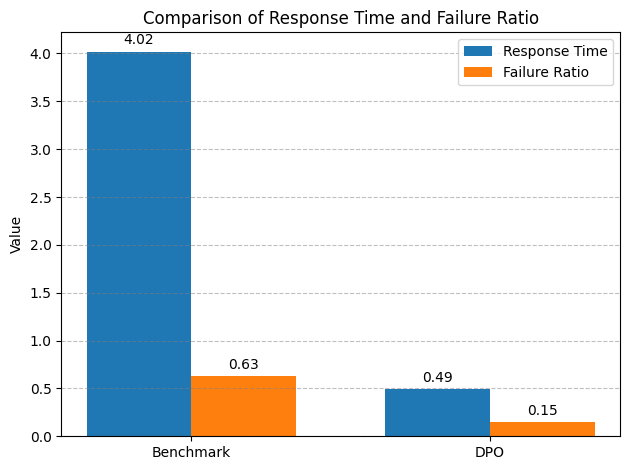

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Benchmark', 'DPO']
response_time = [4.02, 0.49]
failure_ratio = [0.63, 0.15]

# Bar positions
x = np.arange(len(models))
width = 0.35  # Width of each bar

# Create the plot
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, response_time, width, label='Response Time')
bars2 = ax.bar(x + width/2, failure_ratio, width, label='Failure Ratio')

# Add labels, title, ticks
ax.set_ylabel('Value')
ax.set_title('Comparison of Response Time and Failure Ratio')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Add grid
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

# Add bar value labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

# Layout adjustment
plt.tight_layout()
plt.show()
